In [1]:
%pip install findspark pymongo

Note: you may need to restart the kernel to use updated packages.


# Crate Directory and Output File

In [2]:
#Use '/resource' to syncronize folder with host

!mkdir -p ~/output/spark-model/naive-bayes/all-feature

In [3]:
input_path  = '/home/jovyan/output/renamed-data/multi/TrainDataUnderSampling.csv'
output_path = '/home/jovyan/output/spark-model/random-forest/all-feature'

# Import Package

In [4]:
import os
import time
import json
import pyspark
import findspark
from gridfs import GridFS
from datetime import datetime
from pymongo import MongoClient

from pyspark.ml.classification import RandomForestClassifier

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sklearn.metrics import confusion_matrix
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

findspark.init()

# DB Connections

In [5]:
client = MongoClient("mongodb://mongodb:27017")
db = client['mataelanglab']

result_col = db['spark_result']
cv_col = db['spark_cv']
model_col = GridFS(db, 'spark_model')

# Spark session & context

## Local Version

In [6]:
spark = (SparkSession
         .builder
         .master('local[2]')
         .appName('RandomForest-AllFeature')
         .config("spark.executor.memory", "4g") #optional
         .config("spark.executor.cores","1") #optional
         .getOrCreate())
sc = spark.sparkContext

## Cluster Version

<b>Note : </b> \
Jika menggunakan mode ini pastikan data dapat diakses oleh masing worker yang ada. \
Apabila menggunakan cluster pada MataElangLab (1 master dan 1 worker), taruh data pada '/resource'

In [ ]:
spark_uri = os.environ['SPARK_MASTER']
print(spark_uri) #MataElangLab Spark Cluster URL

In [ ]:
spark = (SparkSession
         .builder
         .master(spark_uri)
         .appName('RandomForest-AllFeature')
         .config("spark.executor.memory", "2g") #optional
         .config("spark.executor.cores","1") #optional
         .getOrCreate())
sc = spark.sparkContext

# Read Data

In [7]:
df = spark.read.csv(input_path, header="true", inferSchema =True)

# Normalize

In [8]:
df = df.select([F.col(column).cast('double') for column in df.columns])

# Classification Using All Feature

In [9]:
feature = [
    'flow_duration',
	'total_fwd_packet',
	'total_bwd_packets',
	'total_length_of_fwd_packet',
	'total_length_of_bwd_packet',
	'fwd_packet_length_max',
	'fwd_packet_length_min',
	'fwd_packet_length_mean',
	'fwd_packet_length_std',
	'bwd_packet_length_max',
	'bwd_packet_length_min',
	'bwd_packet_length_mean',
	'bwd_packet_length_std',
	'flow_bytes_per_s',
	'flow_packets_per_s',
	'flow_iat_mean',
	'flow_iat_std',
	'flow_iat_max',
	'flow_iat_min',
	'fwd_iat_total',
	'fwd_iat_mean',
	'fwd_iat_std',
	'fwd_iat_max',
	'fwd_iat_min',
	'bwd_iat_total',
	'bwd_iat_mean',
	'bwd_iat_std',
	'bwd_iat_max',
	'bwd_iat_min',
	'fwd_psh_flags',
	'bwd_psh_flags',
	'fwd_urg_flags',
	'bwd_urg_flags',
	'fwd_header_length',
	'bwd_header_length',
	'fwd_packets_per_s',
	'bwd_packets_per_s',
	'packet_length_min',
	'packet_length_max',
	'packet_length_mean',
	'packet_length_std',
	'packet_length_variance',
	'fin_flag_count',
	'syn_flag_count',
	'rst_flag_count',
	'psh_flag_count',
	'ack_flag_count',
	'urg_flag_count',
	'cwr_flag_count',
	'ece_flag_count',
	'down_per_up_ratio',
	'average_packet_size',
	'fwd_segment_size_avg',
	'bwd_segment_size_avg',
	'fwd_bytes_per_bulk_avg',
	'fwd_packet_per_bulk_avg',
	'fwd_bulk_rate_avg',
	'bwd_bytes_per_bulk_avg',
	'bwd_packet_per_bulk_avg',
	'bwd_bulk_rate_avg',
	'subflow_fwd_packets',
	'subflow_fwd_bytes',
	'subflow_bwd_packets',
	'subflow_bwd_bytes',
	'fwd_init_win_bytes',
	'bwd_init_win_bytes',
	'fwd_act_data_pkts',
	'fwd_seg_size_min',
	'active_mean',
	'active_std',
	'active_max',
	'active_min',
	'idle_mean',
	'idle_std',
	'idle_max',
	'idle_min',
]

# Pre-Processing

In [10]:
#Vector Assembler
vector_assembler = VectorAssembler(inputCols=feature, outputCol="SS_features")
df = vector_assembler.transform(df)

#Standard Scaler
scaler = StandardScaler(inputCol="SS_features", outputCol="scaledFeatures", withStd=True, withMean=False)
df = scaler.fit(df).transform(df)

# Processing

In [11]:
# Split the data
(training_data, test_data) = df.randomSplit([0.7,0.3], 42)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 6208
Test Dataset Count: 2532


In [12]:
start_time = time.time()

# Create Random Forest Classifier object
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")

# Train Random Forest Classifier
rfModel = rf.fit(training_data)

fit_duration = (time.time() - start_time)
print("--- %s seconds ---" % fit_duration)

--- 10.764751195907593 seconds ---


In [13]:
start_time = time.time()

#Predict the response for test dataset
rf_predictions = rfModel.transform(test_data)

pred_duration = (time.time() - start_time)
print("--- %s seconds ---" % pred_duration)

--- 0.182114839553833 seconds ---


In [14]:
# Calculate Confusion matrix
ypred = rf_predictions.select("prediction").collect()
ytest = rf_predictions.select("label").collect()

acc_eval    = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
recall_eval = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedRecall")
prec_eval   = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
f1_eval     = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="f1")

accuracy    = acc_eval.evaluate(rf_predictions)
recall      = recall_eval.evaluate(rf_predictions)
precision   = prec_eval.evaluate(rf_predictions)
f1_score    = f1_eval.evaluate(rf_predictions)

print("confusion matrix :",confusion_matrix(ytest, ypred).ravel())
print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
      "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [453   8   1   5  11  17 497   0   0   0   2   1 512   0   0   1   3  12
 469   0  51  11   0   0 478]
accuracy :  0.9514
recall : 0.9514
precision :  0.9536
f1-measure : 0.9516


In [15]:
# Save Model
ml_path = output_path+"/model"
ss_path = output_path+"/standard-scaler"

!rm -rf $ml_path $ss_path

In [16]:
rfModel.save(ml_path)
scaler.save(ss_path)

In [17]:
# Store to MongoDB

# with open(pickle_path, "rb") as f:
#     model_col.put(f, filename="spark-all-feature")
    
result_col.insert_one({
    'machine_learning': "Random Forest",
    'feature': "All Feature",
    'label': "Multi-Label",
    'fit_duration': fit_duration,
    'pred_duration': pred_duration,
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1_score': f1_score,
    'created_at': datetime.fromtimestamp(time.time())
})

## Calculate Feature Weight to Get Importance Feature

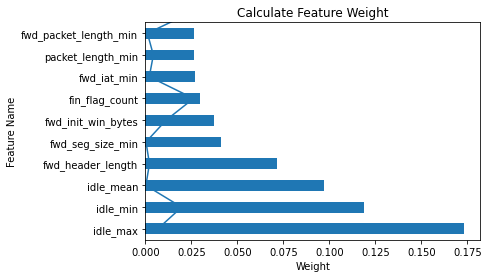

In [18]:
import numpy
import pandas as pd
import numpy as geek
from matplotlib import pyplot as plt 

x = rfModel.featureImportances.toArray()
feature_weigth = x[geek.nonzero(x)]
feature_index = numpy.where(x != 0)[0]
feature_importance = numpy.array(feature)[feature_index]

featureImportances = pd.Series(feature_weigth, index= feature_importance)
featureImportances.nlargest(10).plot(kind='barh')

plt.title('Calculate Feature Weight') 
plt.xlabel('Weight') 
plt.ylabel('Feature Name')
p = plt.plot(featureImportances.values, featureImportances.index)

In [19]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

featureImp = pd.DataFrame({'Feature_names':feature_importance,'Importances':feature_weigth})
featureImp.sort_values(by='Importances',ascending=False)

,Feature_names,Importances
56,idle_max,0.173304
57,idle_min,0.118680
54,idle_mean,0.097117
27,fwd_header_length,0.071808
50,fwd_seg_size_min,0.040925
47,fwd_init_win_bytes,0.037470
36,fin_flag_count,0.029631
21,fwd_iat_min,0.027190
31,packet_length_min,0.026701
6,fwd_packet_length_min,0.026213


In [20]:
sc.stop()